In [32]:
#When running this from .py , import sys and call for conda activate /anaconda3/envs/scrapy

In [5]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


In [6]:
df_met = pd.read_csv('metallica.csv', index_col = 0)
df_met['Artist'] = 'metallica'
df_met.rename(columns={'metallica':'Lyrics'}, inplace=True)
df_pj = pd.read_csv('pearl-jam.csv', index_col = 0)
df_pj['Artist'] = 'pearl-jam'
df_pj.rename(columns={'pearl-jam':'Lyrics'}, inplace=True)
df_queen = pd.read_csv('queen.csv', index_col = 0)
df_queen['Artist'] = 'queen'
df_queen.rename(columns={'queen':'Lyrics'}, inplace=True)

## Match the numbers of rows for every artists - set the others aside for test data ##

### Concatenate the dataframes for individual artists ###

In [7]:
df_lyrics = pd.concat([df_met,df_pj,df_queen], axis = 0, ignore_index=True)

In [8]:
df_lyrics

,Song_name,Lyrics,Artist
0,the shortest straw,"""Suspicion is your name Your honesty to blame ...",metallica
1,all within my hands,"""All within my hands"", ""All within my hands Sq...",metallica
2,low mans lyric,"""My eyes seek reality My fingers seek my veins...",metallica
3,sabbra cadabra,"""Feel so good, I feel so fine Love that little...",metallica
4,just a bullet away,"""All roads they lead to shame All drowning in ...",metallica
...,...,...,...
672,follin around,"""You're so beautiful, you just lay it on me Fo...",queen
673,who needs you,"""I make it half past six you come at seven Alw...",queen
674,rain must fall,"""I can see it in your stars Life is so excitin...",queen
675,fight from the inside,"""Words and music by roger taylor Hey you boy h...",queen


In [149]:
df_lyrics.isna().sum()

Song_name     0
Lyrics       47
Artist        0
dtype: int64

In [150]:
df_lyrics = df_lyrics.dropna(axis = 0)

In [151]:
df_lyrics.shape

(630, 3)

In [152]:
df_lyrics['Lyrics'].value_counts()

"Unfortunately, we are not authorized to show these lyrics"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

### Drop unnecessary junk stuff ###

In [153]:
#df_lyrics = df_lyrics[~df_lyrics['Lyrics'].isin()]
df_lyrics = df_lyrics[~df_lyrics.Lyrics.str.contains("Unfortunately, we are not authorized to show these lyrics")]
df_lyrics = df_lyrics[~df_lyrics.Lyrics.str.contains("(instrumental)")]
df_lyrics = df_lyrics[~df_lyrics.Lyrics.str.contains("Instrumental")]
df_lyrics['Lyrics'] = df_lyrics['Lyrics'].replace(r'\W+|LYRICS|lyrics',' ', regex=True)


/anaconda3/envs/scrapy/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [156]:
df_lyrics

,Song_name,Lyrics,Artist
0,the shortest straw,Suspicion is your name Your honesty to blame ...,metallica
1,all within my hands,All within my hands All within my hands Squee...,metallica
2,low mans lyric,My eyes seek reality My fingers seek my veins...,metallica
3,sabbra cadabra,Feel so good I feel so fine Love that little ...,metallica
4,just a bullet away,All roads they lead to shame All drowning in ...,metallica
...,...,...,...
672,follin around,You re so beautiful you just lay it on me Fox...,queen
673,who needs you,I make it half past six you come at seven Alw...,queen
674,rain must fall,I can see it in your stars Life is so excitin...,queen
675,fight from the inside,Words and music by roger taylor Hey you boy h...,queen


In [157]:
df_lyrics.groupby('Artist').count()

,Song_name,Lyrics
Artist,,
metallica,157,157
pearl-jam,228,228
queen,227,227


## Train - Test Split ##

In [278]:
df_lyrics['ydata'] = df_lyrics['Artist'].map({'metallica': 0, 'pearl-jam': 1, 'queen': 2})

In [279]:
df_lyrics.tail()

,Song_name,Lyrics,Artist,ydata
672,follin around,You re so beautiful you just lay it on me Fox...,queen,2
673,who needs you,I make it half past six you come at seven Alw...,queen,2
674,rain must fall,I can see it in your stars Life is so excitin...,queen,2
675,fight from the inside,Words and music by roger taylor Hey you boy h...,queen,2
676,sheer heart attack,Queen Live Killers Sheer Heart Attack Taylor ...,queen,2


In [280]:
X_train, X_test, y_train, y_test = train_test_split(df_lyrics[['Song_name','Lyrics', 'Artist']], df_lyrics['ydata'], test_size=0.20, random_state=42)

In [281]:
test = pd.concat([X_test, y_test], axis = 1)

In [282]:
test.to_csv('Song_Test.csv')

In [283]:
model = spacy.load('en_core_web_md')

In [284]:
def lemm(x):
    clean = []
    tokens = model(x)
    for token in tokens:
        if not token.is_stop:
            clean.append(token.lemma_)
    return " ".join(clean)
            

In [285]:
X_train

,Song_name,Lyrics,Artist
621,headlong,And you re rushing headlong you ve got a new ...,queen
319,ramblings ii,but i think your drums are no cheep ones hey ...,pearl-jam
358,insignificance,All in all it s no one s fault Excuses turn t...,pearl-jam
147,metal militia,Thunder and lightning the gods take revenge S...,metallica
196,insane,Fuck me in the brain X2 You fuckin little cun...,pearl-jam
...,...,...,...
77,its electric,I m gonna be a rock and roll star Gonna groov...,metallica
118,the thing that should not be,Messenger of Fear in sight Dark deception kil...,metallica
302,the color red,War I m crazy war I m crazy I m war War I m c...,pearl-jam
485,a winters tale,It s Winter fall Red skies are gleaming oh Se...,queen


In [286]:
X_train['Token'] = X_train['Lyrics'].apply(lemm)

In [287]:
X_train

,Song_name,Lyrics,Artist,Token
621,headlong,And you re rushing headlong you ve got a new ...,queen,rush headlong ve get new goal rush headlong ...
319,ramblings ii,but i think your drums are no cheep ones hey ...,pearl-jam,think drum cheep one hey everybody uh eddie ...
358,insignificance,All in all it s no one s fault Excuses turn t...,pearl-jam,s s fault excuse turn carbon wall blame chem...
147,metal militia,Thunder and lightning the gods take revenge S...,metallica,thunder lightne god revenge senseless destru...
196,insane,Fuck me in the brain X2 You fuckin little cun...,pearl-jam,fuck brain x2 fuckin little cunt drivin insa...
...,...,...,...,...
77,its electric,I m gonna be a rock and roll star Gonna groov...,metallica,m go to rock roll star go to groove night da...
118,the thing that should not be,Messenger of Fear in sight Dark deception kil...,metallica,Messenger Fear sight dark deception kill lig...
302,the color red,War I m crazy war I m crazy I m war War I m c...,pearl-jam,War m crazy war m crazy m war War m crazy wa...
485,a winters tale,It s Winter fall Red skies are gleaming oh Se...,queen,s winter fall red sky gleam oh Sea gull flyi...


In [288]:
X_train.groupby('Artist').count()

,Song_name,Lyrics,Token
Artist,,,
metallica,120,120,120
pearl-jam,181,181,181
queen,188,188,188


In [289]:
tv = TfidfVectorizer()

In [290]:
ex = tv.fit_transform(X_train['Token'])

In [291]:
ex

<489x4618 sparse matrix of type '<class 'numpy.float64'>'
	with 23749 stored elements in Compressed Sparse Row format>

In [292]:
tv_train = pd.DataFrame(ex.todense(), columns = tv.get_feature_names()) # dense because we save zeros

In [293]:
tv_train

,000,10,11,12,12th,13,14,15,16,17,...,york,young,youth,yup,zap,zero,zone,zoo,zoom,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086233,0.0


In [308]:
sm = SMOTE(random_state=10, sampling_strategy='auto')

In [309]:
X_sm, y_sm = sm.fit_resample(tv_train, y_train)

In [310]:
X_sm.shape

(564, 4618)

## Implement Naive Bayes ##

## Grid Search CV ## 

In [357]:
m = MultinomialNB()
m_param = {'alpha': [0.0001, 0.001, 0.1 ,1]}

grid_m= GridSearchCV(m,m_param,cv=5)
grid_m.fit( X_sm, y_sm )
ypred = grid_m.predict(X_sm)

best_score = (grid_m.best_score_)
print(best_score, grid_m.best_params_)

0.7802939317319849 {'alpha': 0.001}


In [359]:
from sklearn.naive_bayes import MultinomialNB

In [360]:
m = MultinomialNB(alpha = grid_m.best_params_['alpha'])

In [361]:
m.fit(X_sm, y_sm)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

## TEST ##

In [337]:
X_test

,Song_name,Lyrics,Artist
88,bad seed,Yeah yeah Yeah yeah Oh Bad Yeah Yeah yeah Com...,metallica
245,gremmie out of control,Every beach has a clown who thinks he knows i...,pearl-jam
59,loverman,There s a devil waiting outside your door How...,metallica
663,was it all worth it,What is there left for me to do in this life ...,queen
295,sonic reducer,I don t need anyone don t need no mom and dad...,pearl-jam
...,...,...,...
586,hang on in there,Words and music by queen Don t let go don t l...,queen
585,flash,Flash ah ah Savior of the Universe Flash ah a...,queen
130,killride medley,Guilty as charged But damn it aint right Ther...,metallica
86,leper messiah,Spineless from the start sucked into the part...,metallica


In [349]:
#Make a TV transform of the new song
tv_vec_test = tv.transform(X_test['Lyrics'])

In [350]:
new_song_df = pd.DataFrame(tv_vec_test.todense(), columns=tv.get_feature_names())

In [351]:
new_song_df

,000,10,11,12,12th,13,14,15,16,17,...,york,young,youth,yup,zap,zero,zone,zoo,zoom,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [352]:
y_pred_test = m.predict(new_song_df)

In [353]:
y_pred_test

array([0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 2, 2, 0, 1, 1, 1, 1, 0, 0, 2, 1,
       2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0,
       1, 1, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1, 2, 2, 2,
       1, 1, 1, 1, 0, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1, 2, 1,
       1, 2, 2, 0, 1, 0, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2,
       1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1])

In [328]:
#{'metallica': 0, 'pearl-jam': 1, 'queen': 2}

In [355]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.65      0.54      0.59        37
           1       0.65      0.60      0.62        47
           2       0.59      0.74      0.66        39

    accuracy                           0.63       123
   macro avg       0.63      0.63      0.62       123
weighted avg       0.63      0.63      0.62       123



In [329]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 


In [200]:
#stopwords_in = ['yeah', 're', 'll']
metallica_cloud = ' '
for word in df_lyrics_1['Token'].loc[df_lyrics_1['Artist'] == 'metallica']:
    metallica_cloud = metallica_cloud + word + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(metallica_cloud)

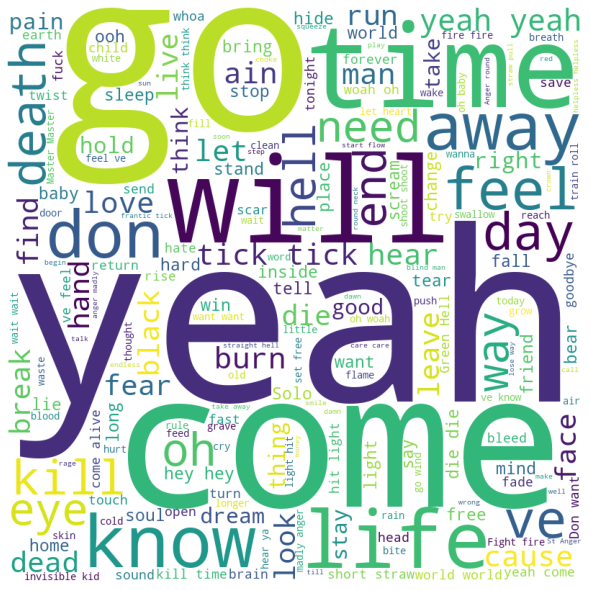

In [201]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.savefig('metallica.png')
plt.show() 


In [202]:
stopwords_pj = ['don']
pj_cloud = ' '
for word in df_lyrics_1['Token'].loc[df_lyrics_1['Artist'] == 'pearl-jam']:
    pj_cloud = pj_cloud + word + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', stopwords = stopwords_pj, 
                min_font_size = 10).generate(pj_cloud)

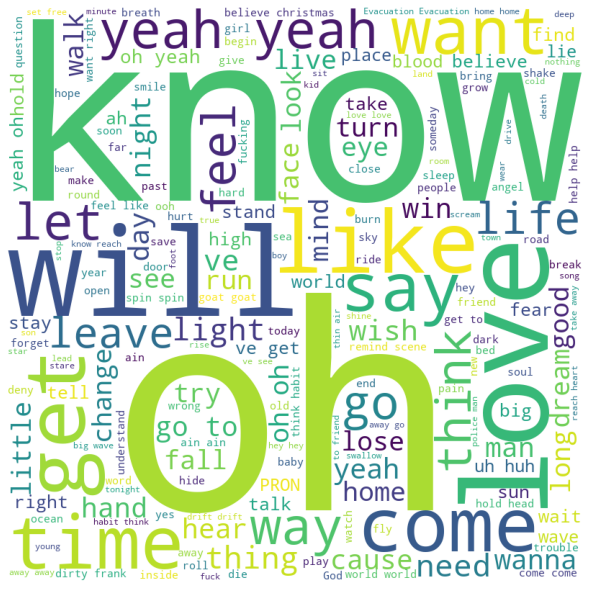

In [203]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('pearljam.png')  
plt.show() 

In [204]:
stopwords_pj = ['don']
queen_cloud = ' '
for word in df_lyrics_1['Token'].loc[df_lyrics_1['Artist'] == 'queen']:
    queen_cloud = queen_cloud + word + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', stopwords = stopwords_pj,
                min_font_size = 10).generate(queen_cloud)

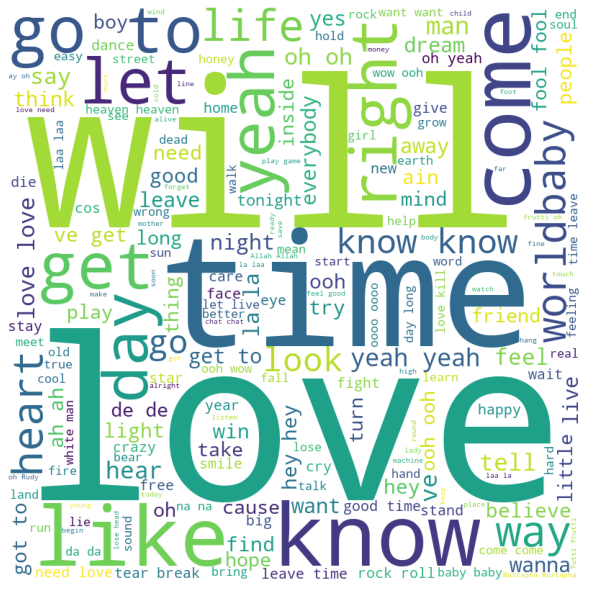

In [205]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('queen.png')  
plt.show() 